<p style="text-align: center; font-size: 300%"> ARCH Models in Julia </p>
<p style="text-align: center; font-size: 200%"> Simon A. Broda </p>
<p style="text-align: center; font-size: 100%"> University of Zurich and University of Amsterdam <br>
<a href="mailto:simon.broda@uzh.ch">simon.broda@uzh.ch</a> </p>
<img src="LOGO_ERC-FLAG_EU_.jpg" alt="LOGO" style="display:block; margin-left: auto; margin-right: auto; width: 20%;">
<p style="text-align: center; font-size: 100%"> This project has received funding from the European Research Council (ERC) under the European Union's Horizon 2020 research and innovation program (grant agreement No. 750559). </p>

# Introduction
* Daily financial returns data exhibit a number of *stylized facts*:
  * Volatility clustering
  * Non-Gaussianity, fat tails
  * Leverage effects: negative returns increase future volatility
* Other types of data (e.g., changes in interest rates) exhibit similar phenomena.
* These effects are important in many areas in finance, in particular in risk management.
* [G]ARCH ([**G**eneralized] **A**utoregressive **C**onditional **V**olatility) models are the most popoular for modelling them.

In [1]:
using MarketData, TimeSeries, Plots, Distributions, KernelDensity, StatPlots
pyplot()
r = percentchange(MarketData.AAPL["Adj. Close"])
p = plot(r)
savefig("returns")

INFO: Precompiling module Plots.
INFO: Recompiling stale cache file /home/broda/.julia/lib/v0.6/Rmath.ji for module Rmath.
INFO: Recompiling stale cache file /home/broda/.julia/lib/v0.6/StatsFuns.ji for module StatsFuns.
INFO: Recompiling stale cache file /home/broda/.julia/lib/v0.6/Distributions.ji for module Distributions.
INFO: Precompiling module KernelDensity.
INFO: Precompiling module IterableTables.
INFO: Precompiling module DataValues.
INFO: Precompiling module TableTraitsUtils.
INFO: Recompiling stale cache file /home/broda/.julia/lib/v0.6/PyPlot.ji for module PyPlot.


## Example: volatility clustering in AAPL returns
<img src="returns.png" alt="RETURNS" style="display:block; margin-left: auto; margin-right: auto; width: 50%;">

In [2]:
plot(kde(r.values), label="Kernel Density")
plot!(fit(Normal,r.values), label="Fitted Normal")
savefig("kde")

## Example: fat tails in AAPL return density
<img src="kde.png" alt="Kernel Density" style="display:block; margin-left: auto; margin-right: auto; width: 50%;">



# (G)ARCH Models
* Basic setup: given a sample of financial returns $\{r_t\}_{t\in\{1,\ldots,T\}}$, decompose $r_t$ as
$$
r_t=\mu_t+\sigma_tz_t, \quad z_t\stackrel{i.i.d.}{\sim}(0,1),
$$
where $\mu_t\equiv\mathbb{E}[r_t\mid \mathcal{F}_{t-1}]$ and $\sigma_t^2\equiv \mathbb{E}[(r_t-\mu_t)^2\mid \mathcal{F}_{t-1}]$.
* Assume $\mu_t=0$ for simplicity. Focus is on the *volatility* $\sigma_t$. G(ARCH) models make $\sigma_t$ a function of *past* returns and variances. Examples: 

## Examples
* ARCH(q) (Engle, Ecta 1982):
$$\sigma_t=\omega+\sum_{i=1}^q \alpha_ir_{t-i}^2,\quad \omega,\alpha_i>0,\quad \sum_{i=1}^q\alpha_i<1.$$
* GARCH(p, q) (Bollerslev, JoE 1986)
$$\sigma_t=\omega+ \sum_{i=1}^p\beta_{i}\sigma_{t-i}^2 + \sum_{i=1}^q\alpha_ir_{t-i}^2,\quad \omega,\alpha_i,\beta_i>0,\quad \sum_{i=1}^{\max p,q} \alpha_i+\beta_i<1.$$
* EGARCH(o, p, q) (Nelson, Ecta 1991)
$$\log(\sigma_t^2)=\omega+\sum_{i=1}^o\gamma_{i}z_{t-i}+\sum_{i=1}^p\beta_i\log(\sigma_{t-i}^2)+\sum_{i=1}^q \alpha_i (|z_t|-\mathbb{E}|z_t|), \quad \sum_{i=1}^p \beta_i<0.$$
 
  



## Estimation
* G(ARCH) models are usually estimated by maximum likelihood: with $f$ denoting te density of $z_t$,
$$\max \prod_t\frac{1}{\sigma_t}f(r_t/\sigma_t).$$
* Recursive nature of $\sigma_t$ means the computation cannot be "vectorized" $\Rightarrow$ loops.
* Julia is very well suited for this. Matlab (and the `rugarch` package for Python) have to implement the likelihood in C.



# The ARCH Package
* ARCH.jl is not registered yet; available at https://github.com/s-broda/ARCH.jl
* 0.6 only so far; 0.7 support coming soon.
* supported so far: simulation and estimation for ARCH, GARCH, and EGARCH models of arbitrary orders, with Gaussian and Student's $t$ errors.
* Designed to be easily extensible with new models, distributions.
* Volatility specifications are structs that subtype `VolatilitySpec`. Parametrized on $(o, p, q)$ to facilitate loop unrolling.
* Simulation and estimation return instances of `ARCHModel`, which subtypes `StatisticalModel` from `StatsBase`.
* Standard errors obtained by automatic differentiation via `ForwardDiff.jl`.

## Usage

In [5]:
using ARCH
srand(1); T=10^4 #sample size
volaspec = GARCH{1, 1}([1., .9, .05]) #[omega, beta, alpha]
am = simulate(volaspec, T; dist=StdTDist(3.)) #returns ARCHModel
fit(GARCH{1, 1}, am.data; dist=StdTDist) #returns ARCHModel


GARCH{1,1} model with Student's t errors, T=10000.


Mean equation parameters:

       Estimate Std.Error  z value Pr(>|z|)
μ    0.00312101 0.0282643 0.110422   0.9121

Volatility parameters:

      Estimate  Std.Error z value Pr(>|z|)
ω      1.01605   0.160286 6.33896    <1e-9
β₁    0.898115  0.0120845 74.3195   <1e-99
α₁   0.0548009 0.00750701 7.29996   <1e-12

Distribution parameters:

     Estimate Std.Error z value Pr(>|z|)
ν     2.93798  0.095268 30.8391   <1e-99



In [6]:
#select an EGARCH model without intercept by minimizing AIC; o, p, q < 3
selectmodel(EGARCH, am.data; meanspec=NoIntercept, criterion=aic, maxlags=2, dist=StdTDist)


EGARCH{1,1,1} model with Student's t errors, T=10000.


Volatility parameters:

       Estimate  Std.Error  z value Pr(>|z|)
ω      0.155388  0.0234126  6.63692   <1e-10
γ₁   0.00550377 0.00945916 0.581846   0.5607
β₁     0.954636 0.00730722  130.643   <1e-99
α₁     0.145216  0.0149484  9.71446   <1e-21

Distribution parameters:

     Estimate Std.Error z value Pr(>|z|)
ν     2.92954 0.0945454 30.9856   <1e-99



# Benchmarks
  * Bollerslev and Ghysels (JBES 1996) data is de facto standard in comparing implementations of GARCH models.
  * Data consist of daily German mark/British pound exchange rates (1974 observations).

INFO: Recompiling stale cache file /home/broda/.julia/lib/v0.6/HTTP.ji for module HTTP.


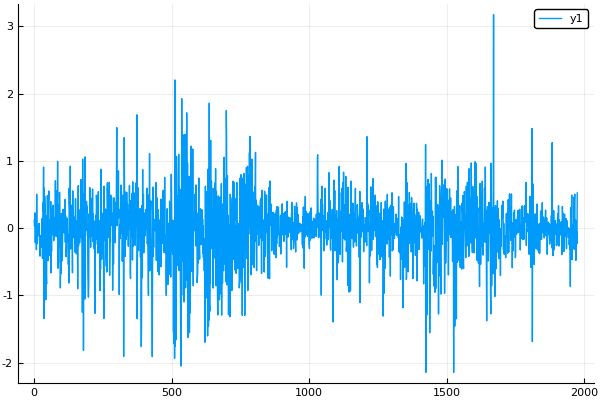

In [7]:
using HTTP
isfile("DMGBP.txt") || open("DMGBP.txt", "w") do io
    HTTP.get("http://people.stern.nyu.edu/wgreene/Text/Edition7/TableF20-1.txt", response_stream=io)
end
r = convert.(Float64, readcsv("DMGBP.txt")[2:end]);
plot(r)

## GARCH
* Fitting in Julia:

In [8]:
using ARCH, BenchmarkTools
@btime fit(GARCH{1, 1}, $r, meanspec=NoIntercept) #Matlab doesn't use an intercept

  12.972 ms (2330 allocations: 113.77 KiB)


InterruptException: [91mInterruptException:[39m

* Now Matlab:

In [ ]:
using MATLAB

In [ ]:
#run this cell a few times to give Matlab a fair chance
mat"tic; estimate(garch(1, 1), $r); toc; 0";

* ARCH.jl is faster by a factor of about 10.
* Estimates are quite similar, but the standard errors and $t$-statistics are not.

* So which standard errors are correct? Let's compare with the results from Brooks et. al. (Int. J. Fcst. 2001).
* They use a model with intercept, so let’s re-estimate in Julia (not sure how to include an intercept in Matlab):

In [ ]:
@btime fit(GARCH{1, 1}, $r)

* Brooks et. al. give the estimates (**$t$-stats**)
$\mu=−0.00619$ $(\mathbf{−0.67})$, $\omega=0.0108$ $(\mathbf{1.66})$, $\beta_1=0.806$ $(\mathbf{11.11})$, $\alpha_1=0.153$ $(\mathbf{2.86})$.
* We are pretty close. Difference is due to the way presample values are computed. We can match Brooks et. al. exactly if we use the historical instead of the unconditional variance.

## EGARCH
* Julia:

In [ ]:
@btime fit(EGARCH{1, 1, 1}, $r, meanspec=NoIntercept)

* Matlab:

In [ ]:
mat"tic; estimate(egarch(1, 1), $r); toc; 0" #Matlab sets o=q

* Brooks et. al. give no benchmark results. But again, Julia is faster by a factor of about 10.

#  TODO
*  0.7 compatibility
*  docs
*  forecasting
*  More models, distributions
*  Value at Risk
*  backtesting
*  MGARCH


# References
* Bollerslev, T (1986). Generalized autoregressive conditional heteroskedasticity. *Journal of Econometrics* **31**, 307–327.
* Bollerslev, T. & Ghysels, E. (1996). Periodic Autoregressive Conditional Heteroscedasticity. *Journal of Business & Economic Statistics* **14**, 139-151. https://doi.org/10.1080/07350015.1996.10524640.
* Brooks, C., Burke, S. P., & Persand, G. (2001). Benchmarks and the accuracy of GARCH model estimation. *International Journal of Forecasting* **17**, 45-56. https://doi.org/10.1016/S0169-2070(00)00070-4.
* Engle, R. F. (1982). Autoregressive Conditional Heteroscedasticity with Estimates of the Variance of United Kingdom Inflation. *Econometrica* **50**, 987-1007. https://doi.org/10.2307/1912773.
* Nelson, D.B. (1991). Conditional Heteroskedasticity in Asset Returns: A New Approach. *Econometrica* **59**, 347--370. https://doi.org/10.2307/2938260.

